In [1]:
import os
import sys
sys.path.append("../")
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
from glob import glob
from tqdm import trange
from typing import List,Tuple
from data_processing.data_loader import dataset_loader
from losses import euclidean_distance_loss,endpoint_loss
from models import endpoint_in_model,conv1x1_endpoint_in_model,coordconv1x1_endpoint_in_model
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
from config import params,generalization_model_params as g_params
import json 
print(tf.__version__)

os.environ['CUDA_VISIBLE_DEVICES']="4,5,6"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



2.3.0
Num GPUs Available:  3


In [11]:
dataset_dir = '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records'
#ds_loader = dataset_loader(tfrec_dir=params.get("dataset_dir"), batch_size=32,normalize_coords=True,normalize_factor=1)
ds_loader = dataset_loader(tfrec_dir=dataset_dir, batch_size=32,normalize_coords=True,normalize_factor=1)
#ds_train, ds_valid, ds_test = ds_loader.build_dataset()
ds_train, ds_valid, ds_test = ds_loader.build_scenario_dataset(consider_scenes=10,no_train_scene=8,no_valid_scene=1,no_test_scene=1)
#ds_train, ds_valid, ds_test = ds_loader.build_scenario_dataset(consider_scenes=13,no_train_scene=10,no_valid_scene=1,no_test_scene=2)


Scenarios:['/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records/scenario1', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records/scenario2', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records/scenario3', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records/scenario4', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records/scenario5', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records/scenario_ph_11', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records/scenario_ph_12', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records/scenario_ph_13', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records/scenario_ph_14', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records/scenario_ph_15']
Building Dataset.......

Number of records, Train files:610, validation files:109, Test Files:98
((TensorSpec(shape=(None, 1536, 1536), dtype=tf.int8, name=None),
  TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=N

In [12]:
def get_test_ds_size(ds_test):
    num_of_samples=0
    for input_batch, output_batch in ds_test:
        for i in range(len(input_batch[0].numpy())):
            num_of_samples+=1
    return num_of_samples

def get_np_test_ds(ds_test):

    samples = get_test_ds_size(ds_test)
    np_tst_gridmap = np.zeros(shape=(samples,1536,1536))
    np_tst_grid_org_res = np.zeros(shape=(samples,3))
    np_tst_left_bnd = np.zeros(shape=(samples,25,2))
    np_tst_right_bnd = np.zeros(shape=(samples,25,2))
    np_tst_car_odo = np.zeros(shape=(samples,3))
    np_tst_init_path = np.zeros(shape=(samples,25,2))
    np_tst_opt_path = np.zeros(shape=(samples,25,2))
    list_tst_file_details = []

    j=0
    for input_batch, output_batch in ds_test:
        
        for i in range(0,len(input_batch[0].numpy())):
            np_tst_gridmap[j]=input_batch[0][i].numpy()
            np_tst_grid_org_res[j] = input_batch[1][i].numpy()
            np_tst_left_bnd[j] = input_batch[2][i].numpy()
            np_tst_right_bnd[j] = input_batch[3][i].numpy()
            np_tst_car_odo[j] = input_batch[4][i].numpy()
            np_tst_init_path[j] = input_batch[5][i].numpy()
            list_tst_file_details.append(input_batch[6][i])

            np_tst_opt_path[j] = output_batch[i].numpy()
            j=j+1   
    return np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path

In [13]:
#get numpy arrays of input test data

np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path =get_np_test_ds(ds_test)


In [14]:
#plot all inputs on gridmap(also an input)

def plot_scene(features,normalized_coords:bool=True,normalized_factor = 1):    
    grid_map = features["grid_map"]
    grid_org = features["grid_org_res"] #[x,y,resolution]
    left_bnd = features["left_bnd"]
    right_bnd = features["right_bnd"]
    init_path = features["init_path"]
    opt_path = features["opt_path"]
    car_odo = features["car_odo"]

    predict_path = features["opt_path"]

    file_details=features["file_details"]

    #print(type(grid_map))
    
    plt.figure(figsize=(10, 10),dpi=200)
    #ax=fig.add_subplot(1,1,1)
    if normalized_coords:
        #res = grid_org[2]
            plt.plot(
                left_bnd[:, 0]*normalized_factor,
                left_bnd[:, 1]*normalized_factor,
                "-.",
                color="magenta",
                markersize=0.5,
                linewidth=0.5,
            )

            plt.plot(
                init_path[:, 0]*normalized_factor,
                init_path[:, 1]*normalized_factor,
                "o-",
                color="lawngreen",
                markersize=1,
                linewidth=1,
            )
            plt.plot(
                opt_path[:, 0]*normalized_factor,
                opt_path[:, 1]*normalized_factor,
                "--",
                color="yellow",
                markersize=1,
                linewidth=1,
            )
            
            plt.plot(
                predict_path[:, 0]*normalized_factor,
                predict_path[:, 1]*normalized_factor,
                "--",
                color="orange",
                markersize=1,
                linewidth=1,
            )

            plt.plot(
                right_bnd[:, 0]*normalized_factor,
                right_bnd[:, 1]*normalized_factor,
                "-.",
                color="magenta",
                markersize=0.5,
                linewidth=0.5,
            )

            plt.plot(
                car_odo[0]*normalized_factor,
                car_odo[1]*normalized_factor,
                "r*",
                color="red",
                markersize=8,
            )

    else:
        res = grid_org[2]
        plt.plot((left_bnd[:,0]-grid_org[0])/res,(left_bnd[:,1]-grid_org[1])/res,'-.', color='magenta',markersize=0.5, linewidth=0.5)

        plt.plot((init_path[:,0]-grid_org[0])/res,(init_path[:,1]-grid_org[1])/res,'o-', color='lawngreen',markersize=1, linewidth=1)

        plt.plot((opt_path[:,0]-grid_org[0])/res,(opt_path[:,1]-grid_org[1])/res,'--', color='yellow',markersize=1, linewidth=1)

        #plt.plot((predict_path[:,0]-grid_org[0])/res,(predict_path[:,1]-grid_org[1])/res,'--', color='orange',markersize=1, linewidth=1)

        plt.plot((right_bnd[:,0]-grid_org[0])/res,(right_bnd[:,1]-grid_org[1])/res, '-.',color='magenta',markersize=0.5, linewidth=0.5)

        plt.plot((car_odo[0]-grid_org[0])/res,(car_odo[1]-grid_org[1])/res,'r*', color = 'red',markersize=8)


    plt.legend(['Left bound', 'gt_init_path', 'gt_opt_path','predicted_path','right bound', 'car_centre'], loc='lower left')

    plt.imshow(grid_map,origin="lower",cmap='gray')
    plt.colorbar()
    plt.title(f"{file_details}\nTest Index: {features['testidx']}")
    #save_fig_dir = '/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results/all_testset_results'
    
    #print(type(file_details))

    #return ax,fig

    """
    print((init_path[:,0]-grid_org[0])/res,(init_path[:,1]-grid_org[1])/res)
    print((predict_path[:,0]-grid_org[0])/res,(predict_path[:,1]-grid_org[1])/res)
    """



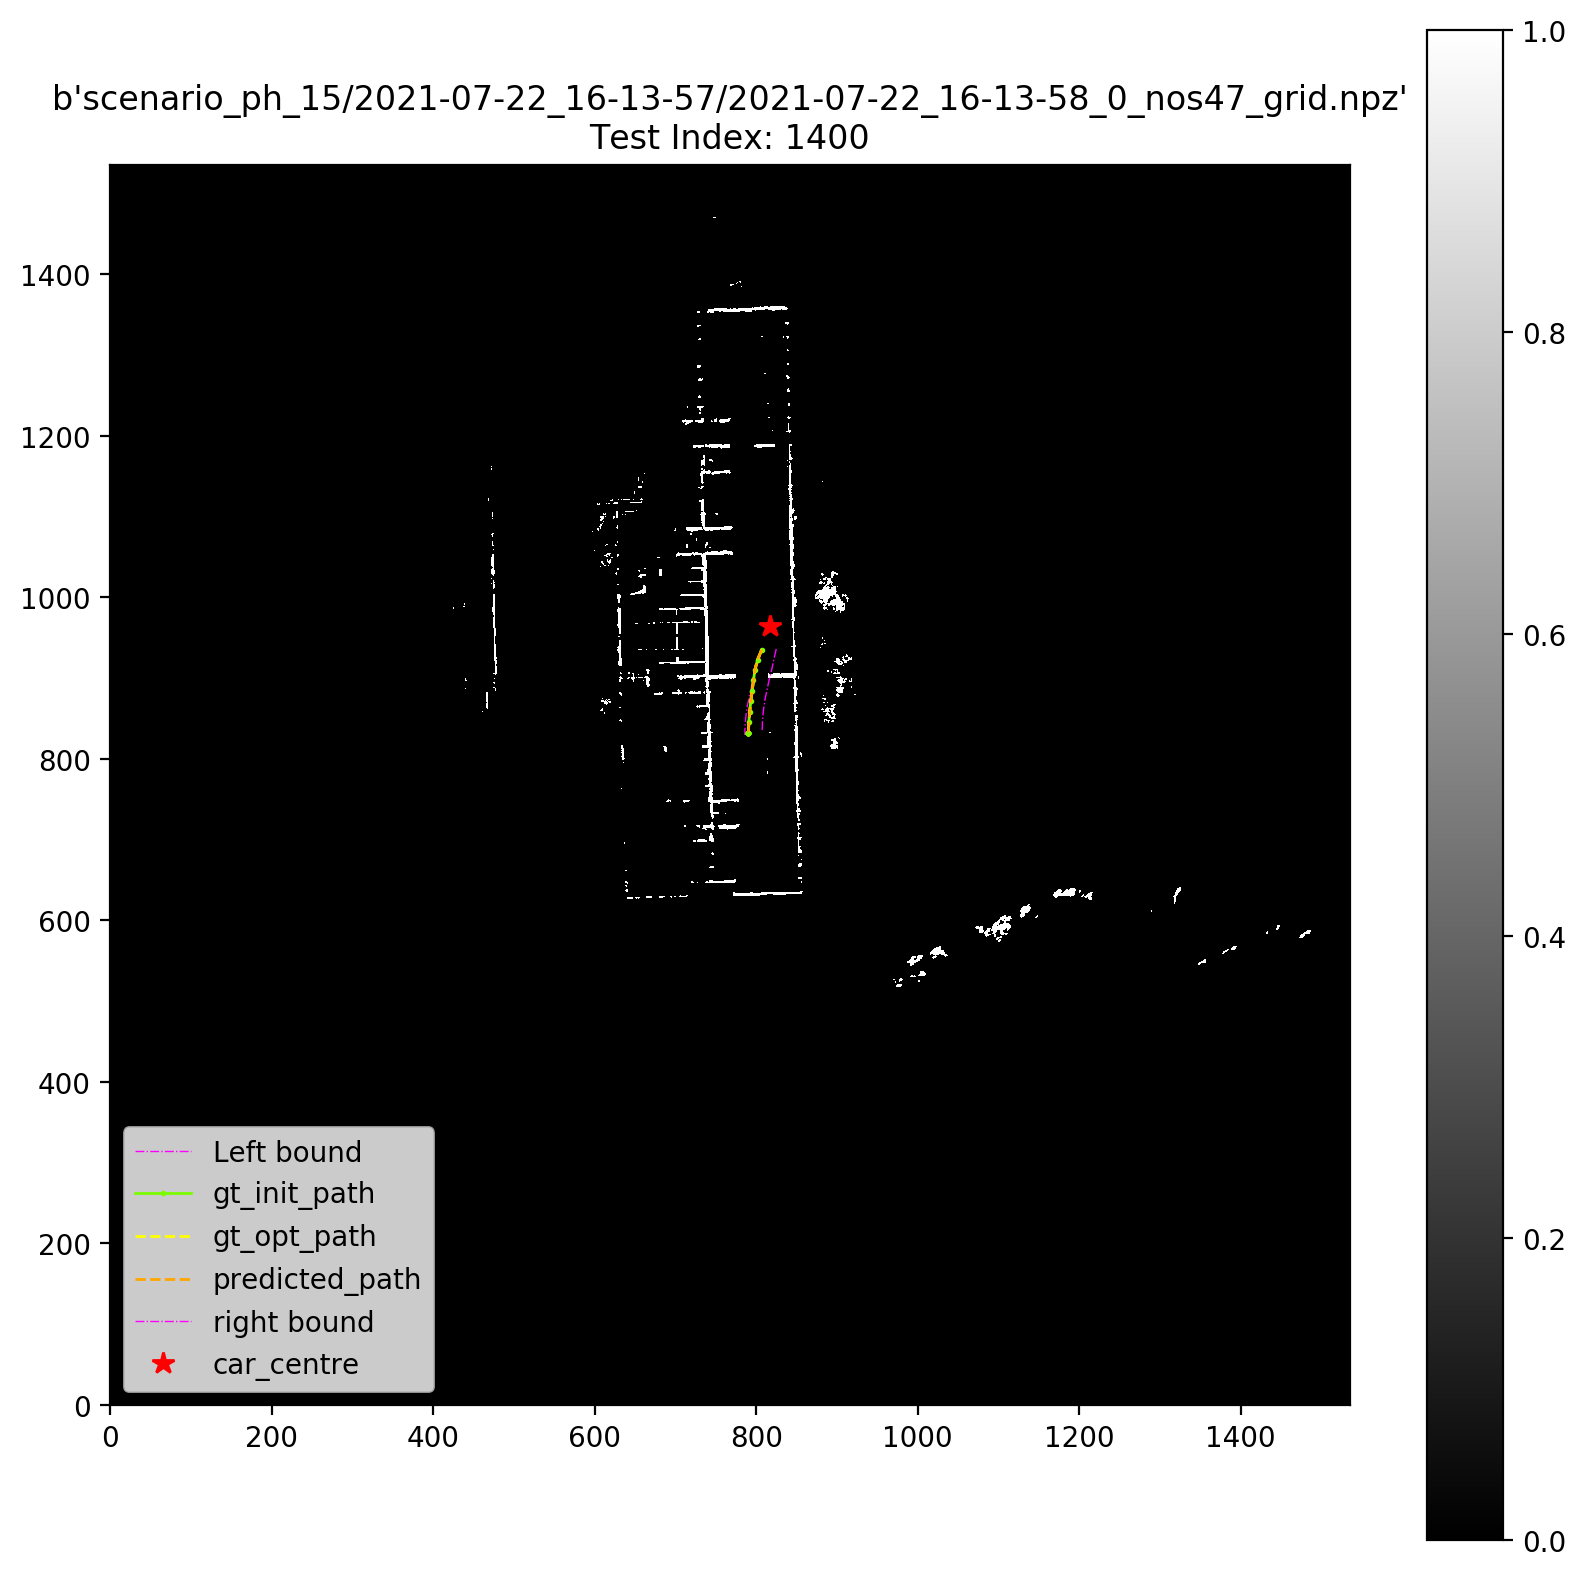

In [15]:
test_idx= 1400#1320#1180#80#143#120#400#1400#200#250#143#1400#320#143#143#250#12#250#10#15#143#12#785#1000#28#530#143#120#15#1300#530#320#50#1050
#%matplotlib agg
#for test_idx in trange(0,len(np_tst_gridmap)):
test_data = {
    "grid_map": np_tst_gridmap[test_idx],
    "grid_org_res": np_tst_grid_org_res[test_idx],
    "left_bnd": np_tst_left_bnd[test_idx],
    "right_bnd": np_tst_right_bnd[test_idx],
    "car_odo": np_tst_car_odo[test_idx],
    "init_path": np_tst_init_path[test_idx],
    "opt_path": np_tst_opt_path[test_idx],
    #"predictions": predictions[test_idx],
    "file_details": list_tst_file_details[test_idx],
    "testidx": test_idx,
}

    #print(test_data["left_bnd"])
plot_scene(test_data,normalized_coords=True, normalized_factor = 1)

#np.savez('anirush.npz',test_data["grid_map"],test_data['car_odo'])
#print(np.max(costmap))

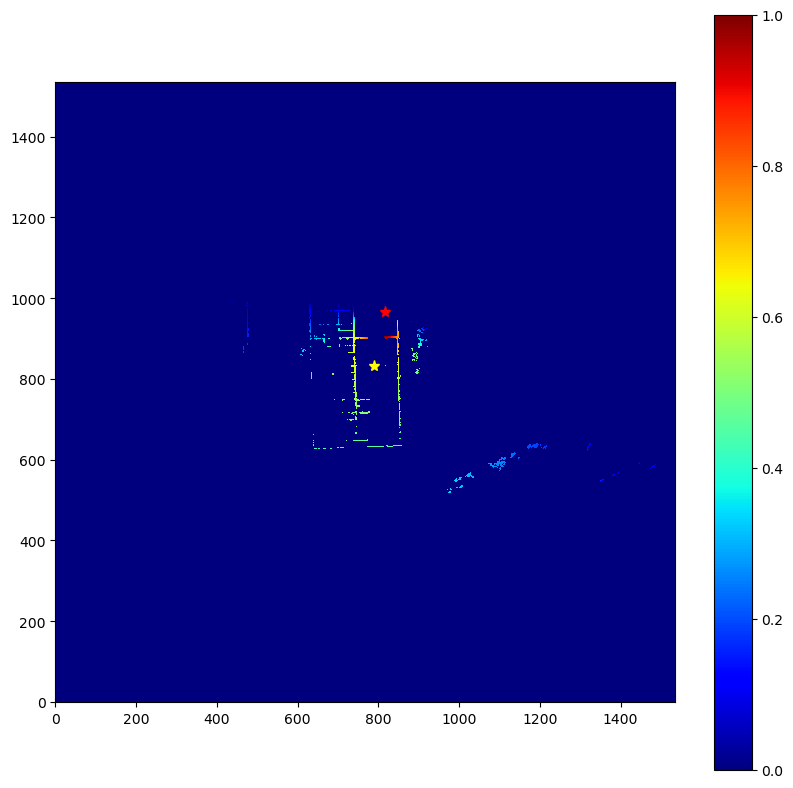

In [21]:
def calc_direction_cost(car_coords:ndarray,endpoint_unit_normal:ndarray,vector:ndarray):
    direction = car_coords-vector
    direction_unit = direction/np.linalg.norm(x=direction)

    direction_cost = np.dot(direction_unit,endpoint_unit_normal)

    return direction_cost

def calc_costmap(gridmap:ndarray,car_odo:ndarray,initial_path:ndarray,include_dir_cost:bool,distance_mag:float=0.40)->ndarray:
    """Function to transfor grid map to cost map

    Args:
        gridmap (ndarray): Binary occupancy grid map
        car_odo (ndarray): [description]
        initial_path (ndarray): [description]
        distance_mag (float, optional): lower it is larger cost considered for the occupied cells. Defaults to 0.40.

    Returns:
        ndarray: [description]
    """
    
    car_coords = car_odo[0:2]
    end_coords = initial_path[-1]

    # Initialize distance and direction costmap 
    dist_costmap = np.zeros(shape=(1536,1536))
    dir_costmap =  np.zeros(shape=(1536,1536))

    ################# calculate distance costmap ################
    
    # get occuppied cell indices
    (y,x) = np.where(gridmap==1)
    # create coordinate pairs of location of occupied cells
    coords = np.array((x,y)).T

    # eucledian difference
    distance = np.square(coords-car_coords)
    distance = np.sum(distance, axis=1)
    distance = 1/(distance**distance_mag)

    dist_costmap[(y,x)]=distance

    ################# Direction cost map ######################
    # end point direction
    if include_dir_cost:
        direction_vector = car_coords-end_coords

        # unit vector between, car location and end point
        end_dir_unit = direction_vector/np.linalg.norm(x=direction_vector)

        # calculate dir cost for all occupied cell locations
        direction_cost= np.asarray([calc_direction_cost(car_coords=car_coords,endpoint_unit_normal=end_dir_unit,vector=coord) for coord in coords])

        # zero down all opposite directions to end point
        direction_cost[np.where(direction_cost<0)]=0.0
        #plt.hist(dir_cost)
        dir_costmap[(y,x)] = direction_cost
    else:
        dir_costmap = np.ones(shape=(1536,1536))

    # pointwise multiply distance cost and direction cost
    costmap = dist_costmap*dir_costmap

    # normalize cost map between [0,1]
    costmap = costmap/np.max(costmap)

    return costmap


total_cost_map = calc_costmap(gridmap=test_data["grid_map"],car_odo=test_data["car_odo"],initial_path=test_data["init_path"],include_dir_cost=True,distance_mag=0.23)

car_coords = test_data["car_odo"][0:2]
end_coords = test_data["init_path"][-1]

plt.figure(figsize=(10,10),dpi=100)

#plt.subplot(1,2,1)
#plt.imshow(test_data["grid_map"],origin="lower",cmap = 'gray')
#plt.subplot(1,2,2)

plt.imshow(total_cost_map,origin="lower",cmap='jet')

plt.plot(
    car_coords[0]*1,
    car_coords[1]*1,
    "r*",
    color="red",
    markersize=8,
)

plt.plot(
    end_coords[0]*1,
    end_coords[1]*1,
    "r*",
    color="yellow",
    markersize=8,
)

plt.colorbar()

car odo :[816.81329346 964.78674316   4.4669261 ], end coords: [790.31750488 832.28369141]
[973 974 975 ... 748 749 750] [ 518  518  518 ... 1471 1471 1471]
[[973 518]
 [974 518]]
dir cost:0.0


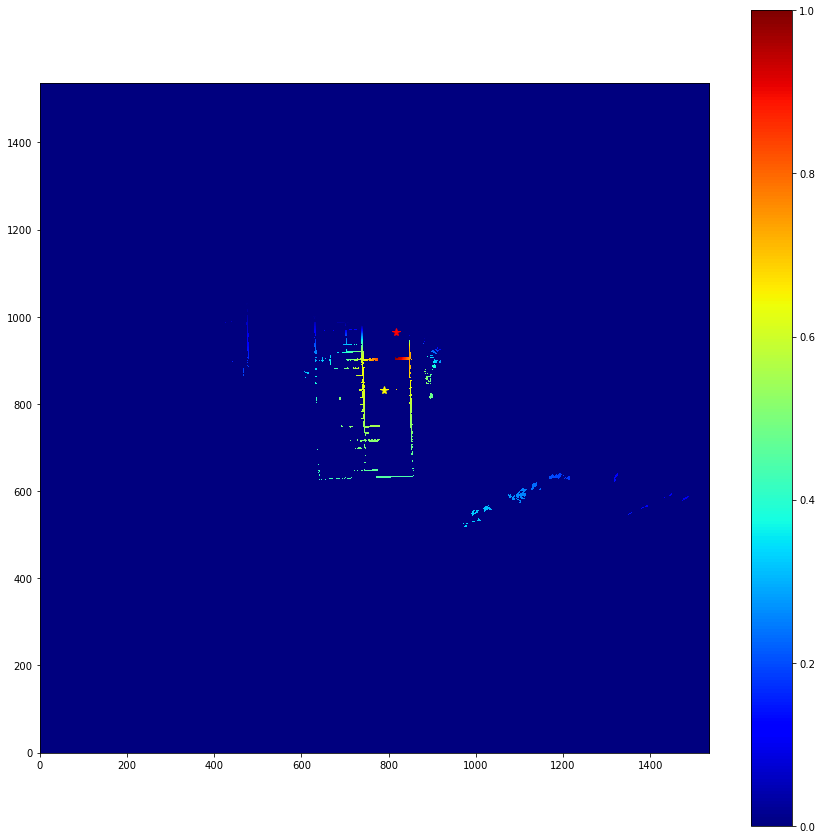

In [14]:

car_coords = test_data["car_odo"][0:2]
end_coords = test_data["init_path"][-1]
print(f'car odo :{test_data["car_odo"]}, end coords: {end_coords}')
costmap = np.zeros(shape=(1536,1536))
dir_costmap = np.zeros(shape=(1536,1536))

a = test_data["grid_map"]
#costmap = a

# = np.argwhere(a>0)
#print(xx,yy)
#a[idx[0]]
(y,x) = np.where(a==1)
print(x,y)
coords = np.array((x,y)).T
print(coords[0:2])
d = np.square(coords-car_coords)

d= np.sum(d,axis=1)
#d = np.sqrt(d)

direction = car_coords-end_coords
end_dir = direction/np.linalg.norm(x=direction)


def calc_direction(car_coords,vector):
    direction = car_coords-vector
    direction_unit = direction/np.linalg.norm(x=direction)

    direction_cost = np.dot(direction_unit,end_dir)

    return direction_cost

dir_cost=np.asarray([calc_direction(car_coords,coord) for coord in coords])

dir_cost[np.where(dir_cost<0)]=0.0
#plt.hist(dir_cost)
dir_costmap[(y,x)] = dir_cost

print(f"dir cost:{np.min(dir_cost)}")


d = 1/(d**0.23)
costmap[(y,x)]=d


costmap = costmap*dir_costmap
costmap = costmap/np.max(costmap)


plt.figure(figsize=(15,15))

#plt.subplot(1,2,1)
plt.imshow(test_data["grid_map"],origin="lower")
"""
#plt.subplot(1,2,2)
"""
plt.imshow(costmap,origin="lower",cmap='jet')
plt.plot(
    car_coords[0]*1,
    car_coords[1]*1,
    "r*",
    color="red",
    markersize=8,
)
plt.plot(
    end_coords[0],
    end_coords[1],
    "r*",
    color="yellow",
    markersize=8,
)

plt.colorbar()


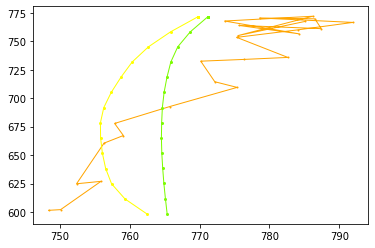

[[765.36505127 598.55456543]
 [765.11920166 611.87591553]
 [764.89776611 625.19769287]
 [764.73114014 638.52020264]
 [764.60266113 651.84313965]
 [764.54608154 665.16662598]
 [764.5814209  678.48999023]
 [764.68414307 691.81298828]
 [764.93261719 705.13409424]
 [765.34423828 718.45043945]
 [765.89428711 731.76165771]
 [766.8805542  745.04718018]
 [768.67077637 758.21044922]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]
 [771.15014648 771.26885986]]


In [14]:
plt.plot(predictions[test_idx][:,0],predictions[test_idx][:,1],'-o', color = 'orange', markersize=1, linewidth=1)
plt.plot(np_tst_init_path[test_idx][:,0],np_tst_init_path[test_idx][:,1],'-o', color='lawngreen',markersize=2, linewidth=1)
plt.plot(np_tst_opt_path[test_idx][:,0],np_tst_opt_path[test_idx][:,1],'-o', color='yellow',markersize=2, linewidth=1)
plt.show()

print(np_tst_init_path[test_idx])

## Scenario based dataset creation

In [1]:
from glob import glob
import random
import numpy as np
path ='/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records'
scenario_list = glob(f"{path}/*")
scenario_list

['/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario1',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario2',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario3',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario4',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario5',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario6',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario7',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario8']

In [2]:
random.Random(2021).shuffle(scenario_list)
scenario_list


['/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario2',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario4',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario1',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario3',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario5',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario6',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario8',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario7']

In [10]:
def collect_tfrec_paths(list_dir):
    assert len(list_dir)>=1
    if len(list_dir)>1 :
        list_in_list= [glob(f"{fold_path}/**/*.tfrec", recursive=True) for fold_path in list_dir]
        flat_list = (np.concatenate(list_in_list).tolist())
    else:

        flat_list=glob(f"{list_dir[0]}/**/*.tfrec", recursive=True)
    return flat_list


In [11]:
len(collect_tfrec_paths(scenario_list[0:6]))

450

In [12]:
scenario_list[0]
glob(f"{scenario_list[0]}/**/*.tfrec", recursive=True)

['/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario1/2021-06-10_08-54-06/2021-06-10_08-54-07_0_file_00-16.tfrec',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario1/2021-06-10_08-54-06/2021-06-10_08-54-07_0_file_01-16.tfrec',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario1/2021-06-10_08-54-06/2021-06-10_08-54-07_0_file_02-16.tfrec',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario1/2021-06-10_08-54-06/2021-06-10_08-54-07_0_file_03-16.tfrec',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario1/2021-06-10_08-54-06/2021-06-10_08-54-07_0_file_04-16.tfrec',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario1/2021-06-10_08-54-06/2021-06-10_08-54-07_0_file_05-15.tfrec',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario1/2021-06-10_08-54-06/2021-06-10_08-55-07_1_file_00-16.tfrec',
 '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records/scenario1/2021-06-10_08

In [13]:
len(collect_tfrec_paths(scenario_list[6:7]))

86

In [15]:
len(collect_tfrec_paths(scenario_list[7:8]))

47